In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [12]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

### Examine data

In [13]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
3637,-117.9,34.0,32.0,1819.0,375.0,1728.0,375.0,4.0,162400.0
3393,-117.9,33.7,24.0,534.0,88.0,249.0,74.0,5.3,240500.0
2693,-117.7,33.6,19.0,2962.0,405.0,1295.0,440.0,6.1,248000.0
4909,-118.1,33.9,43.0,1237.0,243.0,776.0,246.0,4.3,166000.0
8027,-118.4,34.2,34.0,3004.0,589.0,1938.0,568.0,4.2,198600.0


### Normalize values with Z score

In [14]:
# Get the training set metrics
train_df_mean = train_df.mean()
train_df_std = train_df.std()

# Normalize the training set
train_df_norm = (train_df - train_df_mean)/train_df_std

# Normalize the test set (always using the training set metrics)
test_df_norm = (test_df - train_df_mean)/train_df_std

# Examine some values of the normalized training set (Z-scores fall between -3 and 3)
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
3637,0.8,-0.7,0.3,-0.4,-0.4,0.3,-0.3,0.0,-0.4
3393,0.8,-0.9,-0.4,-1.0,-1.1,-1.0,-1.1,0.8,0.3
2693,0.9,-0.9,-0.8,0.1,-0.3,-0.1,-0.2,1.1,0.4
4909,0.7,-0.8,1.1,-0.6,-0.7,-0.6,-0.7,0.2,-0.4
8027,0.6,-0.7,0.4,0.2,0.1,0.4,0.2,0.2,-0.1


### Create a binary label ("median_house_value_is_high")

In [15]:
# the following possible solution uses a Z-score of +1.0 as the threshold, meaning that no more than 16% of the values in median_house_value_is_high will be labeled 1.
threshold_in_Z = 1.0

train_df_norm["median_house_value_is_high"] = (train_df_norm["median_house_value"] > threshold_in_Z).astype(float)

test_df_norm["median_house_value_is_high"] = (test_df_norm["median_house_value"] > threshold_in_Z).astype(float)


### Represent features as input layers

In [16]:
inputs = {
# Features used to train the model on.
  'median_income': tf.keras.Input(shape=(1,)),
  'total_rooms': tf.keras.Input(shape=(1,))
}

### Define functions that create and train a model

Note that, since we are building a Classification model from a Logistic regressor, the activation function used is a sigmoid function.

In [17]:
def create_model(my_inputs, my_learning_rate, METRICS):
  # Use a Concatenate layer to concatenate the input layers into a single tensor.
  # as input for the Dense layer. Ex: [input_1[0][0], input_2[0][0]]
  concatenated_inputs = tf.keras.layers.Concatenate()(my_inputs.values())
  dense = layers.Dense(units=1, name='dense_layer', activation=tf.sigmoid)
  dense_output = dense(concatenated_inputs)
  """Create and compile a simple classification model."""
  my_outputs = {
    'dense': dense_output,
  }
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.
  model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=my_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=METRICS)
  return model


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist

### Define a plot function

In [18]:
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

### Invoke the defined functions

Epoch 1/20
170/170 [==============================] - 0s 937us/step - loss: 0.7760 - accuracy: 0.1639
Epoch 2/20
170/170 [==============================] - 0s 908us/step - loss: 0.6784 - accuracy: 0.1886
Epoch 3/20
170/170 [==============================] - 0s 876us/step - loss: 0.5952 - accuracy: 0.3262
Epoch 4/20
170/170 [==============================] - 0s 882us/step - loss: 0.5254 - accuracy: 0.6316
Epoch 5/20
170/170 [==============================] - 0s 900us/step - loss: 0.4692 - accuracy: 0.7781
Epoch 6/20
170/170 [==============================] - 0s 900us/step - loss: 0.4250 - accuracy: 0.8296
Epoch 7/20
170/170 [==============================] - 0s 900us/step - loss: 0.3911 - accuracy: 0.8506
Epoch 8/20
170/170 [==============================] - 0s 888us/step - loss: 0.3661 - accuracy: 0.8609
Epoch 9/20
170/170 [==============================] - 0s 888us/step - loss: 0.3477 - accuracy: 0.8656
Epoch 10/20
170/170 [==============================] - 0s 900us/step - loss: 0.334

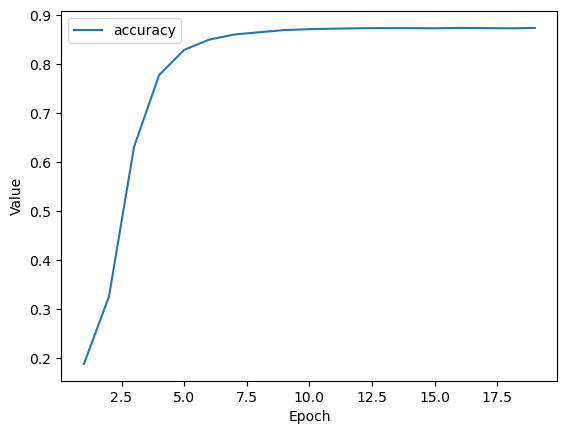

In [20]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy',
                                           threshold=classification_threshold),
          ]

# Establish the model's topography.
my_model = create_model(inputs, learning_rate, METRICS)

# Visualize the model's architecture.
tf.keras.utils.plot_model(my_model, "my_classification_model.png")

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs,
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy']

plot_curve(epochs, hist, list_of_metrics_to_plot)

### Evauating the model agains the test set

In [21]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

30/30 [==============================] - 0s 1ms/step - loss: 0.3056 - accuracy: 0.8770


[0.305634081363678, 0.8769999742507935]

### A perfect model would make 100% accurate predictions. Our model makes 87% accurate predictions. 87% sounds good, but note that a model that always guesses "median_house_value_is_high is False" would be 75% accurate.

### Analizing Precision and Recall metrics

Epoch 1/20
170/170 [==============================] - 1s 953us/step - loss: 0.6950 - accuracy: 0.2841 - precision: 0.1696 - recall: 0.8686
Epoch 2/20
170/170 [==============================] - 0s 953us/step - loss: 0.6005 - accuracy: 0.3598 - precision: 0.1860 - recall: 0.8650
Epoch 3/20
170/170 [==============================] - 0s 947us/step - loss: 0.5249 - accuracy: 0.5157 - precision: 0.2310 - recall: 0.8437
Epoch 4/20
170/170 [==============================] - 0s 929us/step - loss: 0.4663 - accuracy: 0.6488 - precision: 0.2918 - recall: 0.8059
Epoch 5/20
170/170 [==============================] - 0s 935us/step - loss: 0.4230 - accuracy: 0.7258 - precision: 0.3455 - recall: 0.7587
Epoch 6/20
170/170 [==============================] - 0s 982us/step - loss: 0.3912 - accuracy: 0.7731 - precision: 0.3937 - recall: 0.7209
Epoch 7/20
170/170 [==============================] - 0s 959us/step - loss: 0.3679 - accuracy: 0.8032 - precision: 0.4350 - recall: 0.6849
Epoch 8/20
170/170 [=======

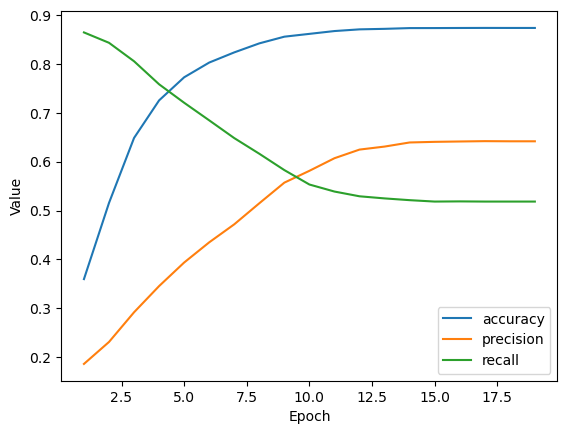

In [23]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.35
label_name = "median_house_value_is_high"

# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy',
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision'
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                                name="recall"),
]

# Establish the model's topography.
my_model = create_model(inputs, learning_rate, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs,
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall']
plot_curve(epochs, hist, list_of_metrics_to_plot)

### The new graphs suggest that precision and recall are somewhat in conflict. That is, improvements to one of those metrics may hurt the other metric.

#### Note that we could spend some time tunning the classification threshold.

### Summarizing the model performance with the AUC metric

Epoch 1/20
170/170 [==============================] - 1s 959us/step - loss: 0.6443 - auc: 0.7706
Epoch 2/20
170/170 [==============================] - 0s 894us/step - loss: 0.5689 - auc: 0.8321
Epoch 3/20
170/170 [==============================] - 0s 911us/step - loss: 0.5087 - auc: 0.8361
Epoch 4/20
170/170 [==============================] - 0s 923us/step - loss: 0.4602 - auc: 0.8380
Epoch 5/20
170/170 [==============================] - 0s 900us/step - loss: 0.4222 - auc: 0.8378
Epoch 6/20
170/170 [==============================] - 0s 917us/step - loss: 0.3922 - auc: 0.8389
Epoch 7/20
170/170 [==============================] - 0s 994us/step - loss: 0.3693 - auc: 0.8392
Epoch 8/20
170/170 [==============================] - 0s 923us/step - loss: 0.3518 - auc: 0.8393
Epoch 9/20
170/170 [==============================] - 0s 911us/step - loss: 0.3386 - auc: 0.8395
Epoch 10/20
170/170 [==============================] - 0s 911us/step - loss: 0.3291 - auc: 0.8396
Epoch 11/20
170/170 [========

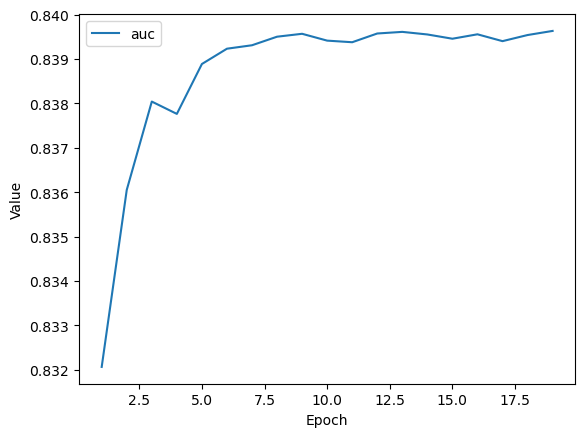

In [24]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# AUC is a reasonable "summary" metric for
# classification models.
# Here is the updated definition of METRICS to
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
my_model = create_model(inputs, learning_rate, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs,
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc']
plot_curve(epochs, hist, list_of_metrics_to_plot)